In [42]:
!pip install flwr[simulation] 

/usr/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=55) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [43]:
!pip install flwr-datasets[vision]

In [44]:
from collections import OrderedDict
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.25.0 / PyTorch 2.8.0+cu126


In [45]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [46]:
NUM_CLIENTS = 3
NUM_ROUNDS = 10
epochs = 3
EPOCHS_PER_ROUND=3
BATCH_SIZE = 32
DATASET_PATH = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"


In [47]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom dataset path - point directly to where CROPPED folders are
from torch.utils.data import Dataset
from PIL import Image

class CroppedImageDataset(Dataset):
    def __init__(self, root_path, transform=None):
        self.transform = transform
        self.samples = []
        self.classes = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 
                        'Parabasal', 'Superficial-Intermediate']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Load images from CROPPED folders
        class_folders = ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 
                        'im_Parabasal', 'im_Superficial-Intermediate']
        
        for class_folder in class_folders:
            # Path: root/im_ClassName/im_ClassName/CROPPED/
            cropped_folder = os.path.join(root_path, class_folder, class_folder, 'CROPPED')
            
            # Get class name without 'im_' prefix
            class_name = class_folder.replace('im_', '')
            class_idx = self.class_to_idx[class_name]
            
            # Check if CROPPED folder exists
            if os.path.exists(cropped_folder):
                # Get all .bmp files
                for img_name in os.listdir(cropped_folder):
                    if img_name.endswith('.bmp'):
                        img_path = os.path.join(cropped_folder, img_name)
                        self.samples.append((img_path, class_idx))
        
        print(f"Loaded {len(self.samples)} images from CROPPED folders")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 1. Load SIPaKMeD using custom dataset (NO transform initially)
dataset = CroppedImageDataset(root_path=DATASET_PATH, transform=None)
print("Classes:", dataset.classes)
print(f"Total dataset size: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")

# 2. Create GLOBAL train/validation split (80/20) BEFORE partitioning
print("\n" + "="*60)
print("CREATING GLOBAL TRAIN/VALIDATION SPLIT")
print("="*60)
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size   # 20% for global validation
train_dataset_raw, val_dataset_raw = random_split(
    dataset, [train_size, val_size]
)
print(f"Training samples (to be partitioned): {len(train_dataset_raw)}")
print(f"Global validation samples (held-out): {len(val_dataset_raw)}")

# Wrapper class to apply transforms to a Subset
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        # Get reference to the base dataset
        self.base_dataset = subset.dataset
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        # Get the actual index in the base dataset
        actual_idx = self.subset.indices[idx]
        # Get image path and label from base dataset
        img_path, label = self.base_dataset.samples[actual_idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Apply train_transform to training set
train_dataset = TransformSubset(train_dataset_raw, transform=train_transform)

# Apply val_transform to validation set
global_val_dataset = TransformSubset(val_dataset_raw, transform=val_transform)

# Create global validation DataLoader (used by ALL clients)
global_valloader = DataLoader(global_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Global validation DataLoader created with {len(global_valloader)} batches")

# 3. Partition ONLY the training data among clients (IID)
print("\n" + "="*60)
print("PARTITIONING TRAINING DATA AMONG CLIENTS (IID)")
print("="*60)

def partition_dataset(dataset, num_clients=NUM_CLIENTS):
    """
    Partition dataset into IID chunks for clients
    """
    data_per_client = len(dataset) // num_clients
    indices = np.random.permutation(len(dataset))
    partitions = []
    
    for i in range(num_clients):
        start = i * data_per_client
        end = (i+1) * data_per_client if i != num_clients-1 else len(dataset)
        client_indices = indices[start:end]
        partitions.append(Subset(dataset, client_indices))
    
    return partitions

# Partition the training data (not the full dataset!)
partitions = partition_dataset(train_dataset, NUM_CLIENTS)

# 4. Each client gets its own DataLoader for TRAINING ONLY
def load_client_train_data(partition_id: int):
    """
    Returns only training DataLoader for a client
    (No local validation split anymore)
    """
    partition = partitions[partition_id]
    trainloader = DataLoader(partition, batch_size=BATCH_SIZE, shuffle=True)
    return trainloader

# 5. Verification and Visualization
print("\n" + "="*60)
print("VERIFICATION AND VISUALIZATION")
print("="*60)
# Example: Get training data for client 0
trainloader = load_client_train_data(0)
print(f"Client 0 training samples: {len(trainloader.dataset)}")
# Show a batch from training
train_batch = next(iter(trainloader))
train_images, train_labels = train_batch
print(f"Training batch shape: {train_images.shape}")
# Show a batch from global validation
val_batch = next(iter(global_valloader))
val_images, val_labels = val_batch
print(f"Global validation batch shape: {val_images.shape}")


Loaded 4049 images from CROPPED folders
Classes: ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']
Total dataset size: 4049
Number of classes: 5

CREATING GLOBAL TRAIN/VALIDATION SPLIT
Training samples (to be partitioned): 3239
Global validation samples (held-out): 810
Global validation DataLoader created with 26 batches

PARTITIONING TRAINING DATA AMONG CLIENTS (IID)

VERIFICATION AND VISUALIZATION
Client 0 training samples: 1079
Training batch shape: torch.Size([32, 3, 128, 128])
Global validation batch shape: torch.Size([32, 3, 128, 128])


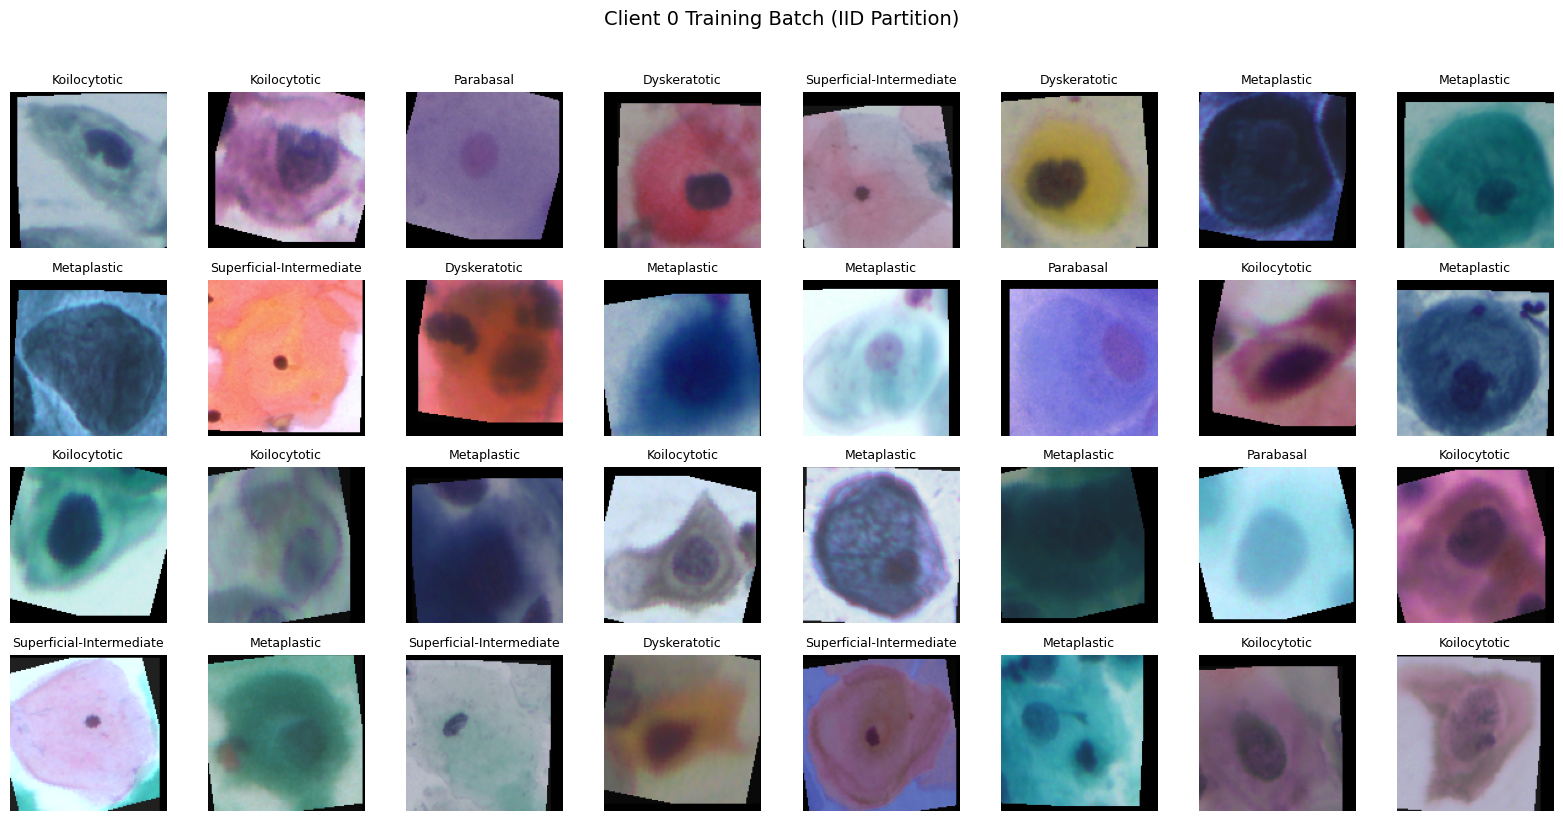

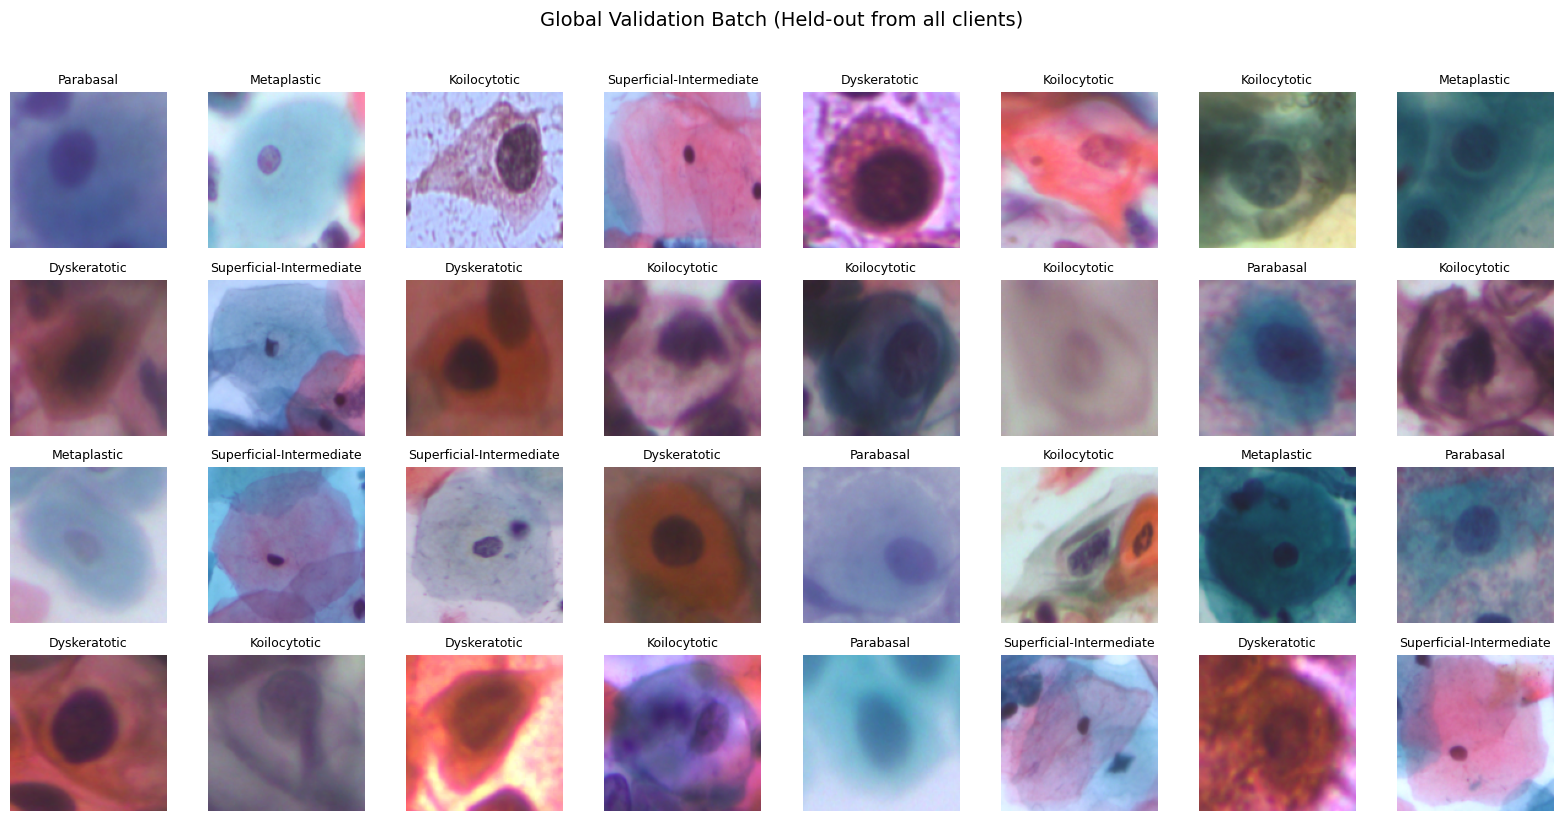

In [48]:
# 6. Create visualization function
def visualize_batch(images, labels, dataset_classes, title):
    """Visualize a batch of images"""
    # Convert for matplotlib
    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    images_np = (images_np * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5]))  # denormalize
    images_np = np.clip(images_np, 0, 1)
    
    fig, axs = plt.subplots(4, 8, figsize=(16, 8))
    fig.suptitle(title, fontsize=14, y=1.02)
    
    for i, ax in enumerate(axs.flat):
        if i < len(images_np):
            ax.imshow(images_np[i])
            ax.set_title(f"{dataset_classes[labels[i].item()]}", fontsize=9)
            ax.axis("off")
        else:
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize training batch (Client 0)
visualize_batch(train_images[:32], train_labels[:32], dataset.classes, 
                "Client 0 Training Batch (IID Partition)")

# Visualize global validation batch
visualize_batch(val_images[:32], val_labels[:32], dataset.classes,
                "Global Validation Batch (Held-out from all clients)")

In [49]:
# class ChannelAttention(nn.Module):
#     """Squeeze-and-Excitation attention for channel-wise feature recalibration"""
#     def __init__(self, channels, reduction=16):
#         super().__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
        
#         self.fc = nn.Sequential(
#             nn.Linear(channels, channels // reduction, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Linear(channels // reduction, channels, bias=False)
#         )
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         b, c, _, _ = x.size()
        
#         # Both average and max pooling
#         avg_out = self.fc(self.avg_pool(x).view(b, c))
#         max_out = self.fc(self.max_pool(x).view(b, c))
        
#         out = avg_out + max_out
#         return x * self.sigmoid(out).view(b, c, 1, 1)

# class SpatialAttention(nn.Module):
#     """Spatial attention for spatial feature recalibration"""
#     def __init__(self, kernel_size=7):
#         super().__init__()
#         self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x_cat = torch.cat([avg_out, max_out], dim=1)
#         attention = self.sigmoid(self.conv(x_cat))
#         return x * attention

# class CBAM(nn.Module):
#     """Convolutional Block Attention Module"""
#     def __init__(self, channels, reduction=16):
#         super().__init__()
#         self.channel_attention = ChannelAttention(channels, reduction)
#         self.spatial_attention = SpatialAttention()
    
#     def forward(self, x):
#         x = self.channel_attention(x)
#         x = self.spatial_attention(x)
#         return x

In [50]:
import torch.nn as nn
import torchvision.models as models


def ResNet18(num_classes=5, dropout = 0.1):
    resnet = models.resnet18(pretrained=True)
    # Replace final classifier (DenseNet uses `classifier`)
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
    return resnet

In [51]:
def print_model_parameters(model):
    """Print detailed parameter information"""
    
    print("=" * 80)
    print("ResNet18 MODEL PARAMETER SUMMARY")
    print("=" * 80)
    
    total_params = 0
    trainable_params = 0
    frozen_params = 0
    
    print("\nLAYER-WISE PARAMETER BREAKDOWN:")
    print("-" * 80)
    
    # Print parameters for each named module
    for name, module in model.named_children():
        module_params = sum(p.numel() for p in module.parameters())
        module_trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
        module_frozen = module_params - module_trainable
        
        total_params += module_params
        trainable_params += module_trainable
        frozen_params += module_frozen
        
        print(f"\n{name}:")
        print(f"  Total params: {module_params:,}")
        print(f"  Trainable params: {module_trainable:,}")
        print(f"  Frozen params: {module_frozen:,}")
        
        # Print sub-modules if they exist
        if hasattr(module, 'named_children'):
            sub_total = 0
            for sub_name, sub_module in module.named_children():
                sub_params = sum(p.numel() for p in sub_module.parameters())
                sub_total += sub_params
                if sub_params > 0:
                    print(f"    ├─ {sub_name}: {sub_params:,}")
            if sub_total > 0:
                print(f"    └─ Sub-total: {sub_total:,}")
    
    print("\n" + "=" * 80)
    print("OVERALL PARAMETER SUMMARY")
    print("=" * 80)
    
    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Frozen Parameters: {frozen_params:,}")
    print(f"Trainable Percentage: {100*trainable_params/total_params:.2f}%")
    
    # Calculate memory usage
    total_memory_mb = total_params * 4 / (1024 ** 2)  # Assuming float32 (4 bytes)
    trainable_memory_mb = trainable_params * 4 / (1024 ** 2)
    
    print(f"\nMemory Usage (float32):")
    print(f"  Total: {total_memory_mb:.2f} MB")
    print(f"  Trainable: {trainable_memory_mb:.2f} MB")
    
    # Model size estimation
    print(f"\nEstimated Model Size:")
    print(f"  ~{total_memory_mb:.1f} MB on disk")
    
    print("\n" + "=" * 80)
    
    return total_params, trainable_params, frozen_params

# Create and analyze the model
print("Initializing ResNet18 model...")
model = ResNet18(num_classes=5, dropout=0.5)

# Get detailed parameter breakdown
total, trainable, frozen = print_model_parameters(model)

# Additional concise summary
print("\n" + "=" * 80)
print("CONCISE SUMMARY")
print("=" * 80)
print(f"Total Parameters: {total:,}")
print(f"Trainable Parameters: {trainable:,}")
print(f"Frozen Parameters: {frozen:,}")
print(f"Trainable %: {100*trainable/total:.2f}%")

# Test forward pass
print("\n" + "=" * 80)
print("FORWARD PASS TEST")
print("=" * 80)
test_input = torch.randn(2, 3, 64, 64)  # Using 64x64 as in your dummy input
try:
    output = model(test_input)
    print(f"✅ Forward pass successful!")
    print(f"   Input shape: {test_input.shape}")
    print(f"   Output shape: {output.shape}")
    print(f"   Expected: [batch_size, num_classes] = [2, 5]")
except Exception as e:
    print(f"❌ Error in forward pass: {e}")
    import traceback
    traceback.print_exc()

Initializing ResNet18 model...
ResNet18 MODEL PARAMETER SUMMARY

LAYER-WISE PARAMETER BREAKDOWN:
--------------------------------------------------------------------------------

conv1:
  Total params: 9,408
  Trainable params: 9,408
  Frozen params: 0

bn1:
  Total params: 128
  Trainable params: 128
  Frozen params: 0

relu:
  Total params: 0
  Trainable params: 0
  Frozen params: 0

maxpool:
  Total params: 0
  Trainable params: 0
  Frozen params: 0

layer1:
  Total params: 147,968
  Trainable params: 147,968
  Frozen params: 0
    ├─ 0: 73,984
    ├─ 1: 73,984
    └─ Sub-total: 147,968

layer2:
  Total params: 525,568
  Trainable params: 525,568
  Frozen params: 0
    ├─ 0: 230,144
    ├─ 1: 295,424
    └─ Sub-total: 525,568

layer3:
  Total params: 2,099,712
  Trainable params: 2,099,712
  Frozen params: 0
    ├─ 0: 919,040
    ├─ 1: 1,180,672
    └─ Sub-total: 2,099,712

layer4:
  Total params: 8,393,728
  Trainable params: 8,393,728
  Frozen params: 0
    ├─ 0: 3,673,088
    ├─ 

In [52]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy

In [53]:
# # 2. Use MUCH smaller learning rate
# import math
# def get_lr_for_round(round_num):
#     initial_lr = 0.001  # Lower initial LR
#     min_lr = 0.00001
#     max_lr = 0.002  # Lower max LR
#     warmup_rounds = 5  # Longer warmup
#     total_rounds = NUM_ROUNDS

#     if round_num <= warmup_rounds:
#         return (max_lr / warmup_rounds) * round_num
#     else:
#         progress = (round_num - warmup_rounds) / (total_rounds - warmup_rounds)
#         cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
#         return min_lr + (max_lr - min_lr) * cosine_decay

# # 3. Update your training with gradient clipping
# def train_safe(net, trainloader, epochs=1, lr=0.00005, max_grad_norm=1.0):
#     """Safe training with gradient clipping"""
#     net.train()
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
#     optimizer = torch.optim.Adam(
#         filter(lambda p: p.requires_grad, net.parameters()), 
#         lr=lr,
#         weight_decay=1e-4,  # Add weight decay
#     )
    
#     running_loss = 0.0
#     running_correct = 0
#     total_samples = 0
    
#     for epoch in range(epochs):
#         for images, labels in trainloader:
#             images, labels = images.to(DEVICE), labels.to(DEVICE)
            
#             optimizer.zero_grad()
#             outputs = net(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
            
#             # CRITICAL: Gradient clipping
#             torch.nn.utils.clip_grad_norm_(
#                 net.parameters(), 
#                 max_norm=max_grad_norm,
#                 norm_type=2
#             )
            
#             optimizer.step()
            
#             running_loss += loss.item() * labels.size(0)
#             running_correct += (outputs.argmax(dim=1) == labels).sum().item()
#             total_samples += labels.size(0)
    
#     if total_samples == 0:
#         return 0.0, 0.0
    
#     avg_loss = running_loss / total_samples
#     avg_acc = running_correct / total_samples
    
#     return avg_loss, avg_acc

In [54]:
# CRITICAL FIX: The problem is BatchNorm running statistics aren't being properly handled
# When you call set_parameters(), you're only updating weights, NOT BatchNorm running_mean/running_var

def set_parameters(net, parameters: list[np.ndarray]):
    """Set trainable model parameters from a list of numpy arrays."""
    # CRITICAL FIX: Only set trainable parameters, preserve BatchNorm buffers
    trainable_params = [p for p in net.parameters() if p.requires_grad]

    if len(parameters) != len(trainable_params):
        print(f"Warning: Parameter mismatch. Model has {len(trainable_params)} trainable params, "
              f"received {len(parameters)} parameters.")
        if len(parameters) == 0:
            print("Using current model parameters (no update)")
            return net

    # Update trainable parameters
    for model_param, new_param in zip(trainable_params, parameters):
        model_param.data.copy_(torch.tensor(new_param, dtype=model_param.dtype))

    return net


# BETTER SOLUTION: Include BatchNorm statistics in parameter exchange
def get_parameters_with_bn(net) -> list[np.ndarray]:
    """Get model parameters including BatchNorm running statistics."""
    params = []
    
    # Add trainable parameters
    for param in net.parameters():
        if param.requires_grad:
            params.append(param.detach().cpu().numpy())
    
    # Add BatchNorm buffers (running_mean, running_var, num_batches_tracked)
    for name, buffer in net.named_buffers():
        if 'running_mean' in name or 'running_var' in name:
            params.append(buffer.detach().cpu().numpy())
    
    return params


def set_parameters_with_bn(net, parameters: list[np.ndarray]):
    """Set model parameters including BatchNorm running statistics."""
    param_idx = 0
    
    # Set trainable parameters
    for param in net.parameters():
        if param.requires_grad:
            param.data.copy_(torch.tensor(parameters[param_idx], dtype=param.dtype))
            param_idx += 1
    
    # Set BatchNorm buffers
    for name, buffer in net.named_buffers():
        if 'running_mean' in name or 'running_var' in name:
            if param_idx < len(parameters):
                buffer.data.copy_(torch.tensor(parameters[param_idx], dtype=buffer.dtype))
                param_idx += 1
    
    return net

In [55]:
import torch.optim as optim
import torch.nn as nn
from flwr.common import Context
from flwr.client import Client

In [56]:
class FlowerClient(NumPyClient):
    def __init__(self, client_id: int, trainloader, net, weight_decay=1e-5 , lr=0.001):
        self.client_id = client_id
        self.trainloader = trainloader
        self.net = net
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.net.to(self.device)
        
        # Lower learning rate with better optimizer settings
        self.optimizer = optim.AdamW(
            self.net.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=(0.9, 0.999)
        )
        
        self.weight_decay = weight_decay
        self.lr = lr
        self.train_history = []
        self.val_history = []

    def get_parameters(self, config):
        """Return model parameters INCLUDING BatchNorm statistics."""
        return get_parameters_with_bn(self.net)

    def fit(self, parameters, config):
        """Train the model on local data"""
        # CRITICAL: Use the new function that handles BatchNorm
        set_parameters_with_bn(self.net, parameters)
        self.net.to(self.device)
        
        # CRITICAL: Set to training mode BEFORE training
        self.net.train()

        lr = config.get("lr", self.lr)
        local_epochs = config.get("epochs", 3)
        
        train_loss, train_acc = self._train_with_lr(
            self.net, self.trainloader, lr, self.weight_decay, local_epochs
        )

        updated_params = self.get_parameters(config)
        num_examples = len(self.trainloader.dataset)

        client_metrics = {
            "client_id": self.client_id,
            "train_loss": float(train_loss),
            "train_accuracy": float(train_acc),
            "learning_rate": lr,
            "num_examples": num_examples,
        }

        return updated_params, num_examples, client_metrics

    def evaluate(self, parameters, config):
        """Evaluate the model on global validation set"""
        # CRITICAL: Use the new function that handles BatchNorm
        set_parameters_with_bn(self.net, parameters)
        self.net.to(self.device)
        
        # CRITICAL: Set to evaluation mode BEFORE evaluation
        self.net.eval()
        
        # VERIFY MODEL IS IN EVAL MODE
        is_training = self.net.training
        print(f"  [Client {self.client_id}] Model in training mode: {is_training}")

        val_loss, val_acc = self._evaluate(self.net, global_valloader)
        num_examples = len(global_valloader.dataset)

        val_metrics = {
            "client_id": self.client_id,
            "val_loss": float(val_loss),
            "val_accuracy": float(val_acc),
            "num_examples": num_examples
        }

        return float(val_loss), num_examples, val_metrics

    def _train_with_lr(self, net, trainloader, lr, weight_decay, epochs):
        """Train with specific learning rate"""
        net.train()  # Ensure training mode
        criterion = nn.CrossEntropyLoss()
    
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            param_group['weight_decay'] = weight_decay
        
        running_loss = 0.0
        running_correct = 0
        total_samples = 0
    
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_correct = 0
            epoch_total = 0
            
            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                self.optimizer.step()
    
                batch_size = labels.size(0)
                epoch_loss += loss.item() * batch_size
                epoch_correct += (outputs.argmax(dim=1) == labels).sum().item()
                epoch_total += batch_size
            
            if epoch_total > 0:
                epoch_avg_loss = epoch_loss / epoch_total
                epoch_avg_acc = epoch_correct / epoch_total
                print(f"    Client {self.client_id} Epoch {epoch+1}/{epochs}: "
                      f"Loss={epoch_avg_loss:.4f}, Acc={epoch_avg_acc:.4f}")
            
            running_loss += epoch_loss
            running_correct += epoch_correct
            total_samples += epoch_total
    
        if total_samples == 0:
            return 0.0, 0.0
    
        return running_loss / total_samples, running_correct / total_samples

    def _evaluate(self, net, val_loader):
        """Evaluate on validation set"""
        net.eval()  
        criterion = nn.CrossEntropyLoss()

        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = net(images)
                loss = criterion(outputs, labels)

                batch_size = labels.size(0)
                running_loss += loss.item() * batch_size
                running_correct += (outputs.argmax(dim=1) == labels).sum().item()
                total_samples += batch_size

        if total_samples == 0:
            return 0.0, 0.0

        return running_loss / total_samples, running_correct / total_samples


In [57]:
import math
def get_lr_for_round(round_num):
    initial_lr = 0.001  # Lower initial LR
    min_lr = 0.00001
    max_lr = 0.002  # Lower max LR
    warmup_rounds = 5  # Longer warmup
    total_rounds = NUM_ROUNDS
    
    if round_num <= warmup_rounds:
        return (max_lr / warmup_rounds) * round_num
    else:
        progress = (round_num - warmup_rounds) / (total_rounds - warmup_rounds)
        cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
        return min_lr + (max_lr - min_lr) * cosine_decay

In [58]:
def get_initial_parameters():
    """Get initial parameters including BatchNorm statistics."""
    model = ResNet18(num_classes=5, dropout= 0.3)
    model = model.to(DEVICE)
    
    # CRITICAL: Initialize BatchNorm properly by doing a forward pass
    model.train()
    dummy_input = torch.randn(1, 3, 128, 128).to(DEVICE)
    
    initial_params = get_parameters_with_bn(model)
    
    from flwr.common import ndarrays_to_parameters
    return ndarrays_to_parameters(initial_params)

In [59]:
from flwr.common import Context
from flwr.client import Client

def client_fn(context: Context) -> Client:
    partition_id = context.node_config["partition-id"]
    cid = int(partition_id)
    trainloader = load_client_train_data(cid)
    
    # Use simpler model with higher dropout
    model = ResNet18(num_classes=5)
    model = model.to(DEVICE)
    
    return FlowerClient(
        client_id=cid, 
        trainloader=trainloader, 
        net=model, 
        weight_decay = 1e-5 ,  # Increased weight decay
        lr=0.005
    ).to_client()

In [60]:
print("\n" + "="*60)
print("DIAGNOSTIC: Check BatchNorm behavior")
print("="*60)
test_model = ResNet18(num_classes=5, dropout=0.3).to(DEVICE)

# Training mode
test_model.train()
# print(f"Model in training mode: {test_model.training}")
# print(f"First BN layer training: {test_model.initial[1].training}")

# Eval mode
test_model.eval()
# print(f"Model in eval mode: {not test_model.training}")
# print(f"First BN layer in eval: {not test_model.initial[1].training}")
# print("="*60 + "\n")


DIAGNOSTIC: Check BatchNorm behavior


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
from flwr.client import ClientApp

# Wrap the client function into a ClientApp
client = ClientApp(client_fn=client_fn)

In [62]:
from flwr.simulation import run_simulation

# Configure resources per client
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

# Define number of rounds


In [63]:
from typing import List, Tuple, Dict
# Global storage for per-client metrics
per_client_train_metrics = []  # List of lists: per_round[client_id] = metrics
per_client_val_metrics = []    # Same for validation

def aggregate_train_metrics_with_client_tracking(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
    """
    Enhanced aggregation that stores per-client metrics
    """
    global per_client_train_metrics
    
    # Debug print
    print(f"\nDEBUG [Round {len(per_client_train_metrics)+1}] Training metrics from clients:")
    
    # Initialize storage for this round
    round_metrics = {}
    
    total_examples = sum(n for n, _ in metrics)
    if total_examples == 0:
        avg_train_loss = 0.0
        avg_train_acc = 0.0
    else:
        # Calculate weighted averages
        weighted_loss = 0.0
        weighted_acc = 0.0
        
        for n, m in metrics:
            client_id = m.get("client_id", -1)
            client_loss = m.get("train_loss", 0.0)
            client_acc = m.get("train_accuracy", 0.0)
            client_lr = m.get("learning_rate", 1e-4)
            
            weighted_loss += n * client_loss
            weighted_acc += n * client_acc
            
            # Store per-client metrics
            if client_id != -1:
                if client_id not in round_metrics:
                    round_metrics[client_id] = []
                round_metrics[client_id].append({
                    "round": len(per_client_train_metrics) + 1,
                    "loss": client_loss,
                    "accuracy": client_acc,
                    "learning_rate": client_lr,
                    "samples": n
                })
                
            print(f"  Client {client_id}: loss={client_loss:.4f}, acc={client_acc:.4f}, "
                  f"lr={client_lr:.6f}, samples={n}")
        
        avg_train_loss = weighted_loss / total_examples
        avg_train_acc = weighted_acc / total_examples
    
    # Store round metrics
    per_client_train_metrics.append(round_metrics)
    
    # Return aggregated metrics for the strategy
    return {
        "train_loss": avg_train_loss,
        "train_accuracy": avg_train_acc,
        "round": len(per_client_train_metrics)
    }

def weighted_average_with_client_tracking(metrics):
    """
    Enhanced validation aggregation with per-client tracking
    """
    global per_client_val_metrics
    
    round_num = len(per_client_val_metrics) + 1
    print(f"\nDEBUG [Round {round_num}] Validation metrics from clients:")
    
    # Initialize storage for this round
    round_val_metrics = {}
    
    total_examples = sum(n for n, _ in metrics)
    
    if total_examples == 0:
        return {"accuracy": 0.0, "loss": 0.0}
    
    weighted_acc = 0.0
    weighted_loss = 0.0
    
    for n, m in metrics:
        client_id = m.get("client_id", -1)
        client_acc = m.get("val_accuracy", m.get("accuracy", 0.0))
        client_loss = m.get("val_loss", m.get("loss", 0.0))
        
        weighted_acc += n * client_acc
        weighted_loss += n * client_loss
        
        # Store per-client validation metrics
        if client_id != -1:
            if client_id not in round_val_metrics:
                round_val_metrics[client_id] = []
            round_val_metrics[client_id].append({
                "round": round_num,
                "loss": client_loss,
                "accuracy": client_acc,
                "samples": n
            })
            
        print(f"  Client {client_id}: loss={client_loss:.4f}, acc={client_acc:.4f}, samples={n}")
    
    avg_acc = weighted_acc / total_examples
    avg_loss = weighted_loss / total_examples
    
    # Store round metrics
    per_client_val_metrics.append(round_val_metrics)
    
    return {"accuracy": avg_acc, "loss": avg_loss}

In [64]:
# from flwr.server.strategy import FedAvg

# class FedAvgSaveParams(FedAvg):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.final_parameters = None

#     def aggregate_fit(self, server_round, results, failures):
#         aggregated = super().aggregate_fit(server_round, results, failures)
#         if aggregated is not None:
#             self.final_parameters = aggregated[0]  # Parameters object
#         return aggregated

In [65]:
# Simpler version - just track parameters
class FedAvgTrackParams(FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.final_parameters = None
        self.all_parameters = []  # Store parameters from each round
        
    def aggregate_fit(self, server_round, results, failures):
        aggregated = super().aggregate_fit(server_round, results, failures)
        
        if aggregated is not None:
            parameters, metrics = aggregated
            self.final_parameters = parameters
            self.all_parameters.append({
                'round': server_round,
                'parameters': parameters,
                'loss': metrics.get('train_loss', 0),
                'accuracy': metrics.get('train_accuracy', 0)
            })
            print(f"DEBUG: Tracked parameters for round {server_round}")
        
        return aggregated

# Update your strategy:
strategy = FedAvgTrackParams(
    fraction_fit=1,
    fraction_evaluate=1,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=3,
    evaluate_metrics_aggregation_fn=weighted_average_with_client_tracking,
    fit_metrics_aggregation_fn=aggregate_train_metrics_with_client_tracking,
    on_fit_config_fn=lambda rnd: {
        "lr": get_lr_for_round(round_num = NUM_ROUNDS),  # Dynamic learning rate
        "epochs": epochs,
        "round": rnd
    },
    on_evaluate_config_fn=lambda rnd: {"final_round": rnd == NUM_ROUNDS}
)


In [66]:
from flwr.server import ServerApp, ServerAppComponents
from flwr.server import ServerConfig

def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

# Create new server instance
server = ServerApp(server_fn=server_fn)

In [67]:
# Run the federated learning simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
(pid=501) 2026-01-25 11:42:43.291868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory 

(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=1.5181, Acc=0.3948


(raylet) [2026-01-25 11:43:04,292 E 252 252] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=1.0866, Acc=0.6302


(pid=298) [2026-01-25 11:43:09,029 E 298 385] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2026-01-25 11:43:09,293 E 55 296] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.8188, Acc=0.7377
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=1.5467, Acc=0.3531
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=1.1104, Acc=0.5996
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.8068, Acc=0.7590
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=1.5385, Acc=0.3525
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=1.0885, Acc=0.6346


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.8173, Acc=0.7530


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 1] Training metrics from clients:
  Client 2: loss=1.1481, acc=0.5800, lr=0.000010, samples=1081
  Client 0: loss=1.1412, acc=0.5876, lr=0.000010, samples=1079
  Client 1: loss=1.1546, acc=0.5706, lr=0.000010, samples=1079
DEBUG: Tracked parameters for round 1
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 1] Validation metrics from clients:
  Client 0: loss=0.7776, acc=0.7765, samples=810
  Client 1: loss=0.7776, acc=0.7765, samples=810
  Client 2: loss=0.7776, acc=0.7765, samples=810
(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=0.6343, Acc=0.8072
(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=0.5251, Acc=0.8184
(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.4457, Acc=0.8582
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=0.6249, Acc=0.8174
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=0.5046, Acc=0.8415
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.4341, Acc=0.8767
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=0.6281, Acc=0.8030
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=0.5096, Acc=0.8474
(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.4371, Acc=0.8622


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 2] Training metrics from clients:
  Client 2: loss=0.5249, acc=0.8375, lr=0.000010, samples=1081
  Client 0: loss=0.5351, acc=0.8279, lr=0.000010, samples=1079
  Client 1: loss=0.5212, acc=0.8452, lr=0.000010, samples=1079
DEBUG: Tracked parameters for round 2
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 2] Validation metrics from clients:
  Client 2: loss=0.4251, acc=0.8827, samples=810
  Client 1: loss=0.4251, acc=0.8827, samples=810
  Client 0: loss=0.4251, acc=0.8827, samples=810
(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=0.4028, Acc=0.8573
(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=0.3634, Acc=0.8758
(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.3103, Acc=0.8990
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=0.4309, Acc=0.8703
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=0.3857, Acc=0.8712
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.3584, Acc=0.8721
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=0.3866, Acc=0.8788
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=0.3910, Acc=0.8631


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.3115, Acc=0.9019


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 3] Training metrics from clients:
  Client 2: loss=0.3630, acc=0.8813, lr=0.000010, samples=1081
  Client 0: loss=0.3588, acc=0.8774, lr=0.000010, samples=1079
  Client 1: loss=0.3917, acc=0.8712, lr=0.000010, samples=1079
DEBUG: Tracked parameters for round 3
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 3] Validation metrics from clients:
  Client 0: loss=0.3008, acc=0.9062, samples=810
  Client 1: loss=0.3008, acc=0.9062, samples=810
  Client 2: loss=0.3008, acc=0.9062, samples=810
(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=0.3113, Acc=0.8869
(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=0.2954, Acc=0.8953
(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.2839, Acc=0.8999
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=0.3555, Acc=0.8869
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=0.3162, Acc=0.8962
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.2812, Acc=0.9064
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=0.3143, Acc=0.8955
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=0.2992, Acc=0.8927


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.2519, Acc=0.9130


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 4] Training metrics from clients:
  Client 0: loss=0.2969, acc=0.8940, lr=0.000010, samples=1079
  Client 1: loss=0.3176, acc=0.8965, lr=0.000010, samples=1079
  Client 2: loss=0.2885, acc=0.9004, lr=0.000010, samples=1081
DEBUG: Tracked parameters for round 4
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 4] Validation metrics from clients:
  Client 1: loss=0.2523, acc=0.9210, samples=810
  Client 2: loss=0.2523, acc=0.9210, samples=810
  Client 0: loss=0.2523, acc=0.9210, samples=810
(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=0.2975, Acc=0.8981
(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=0.2658, Acc=0.9082
(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.2858, Acc=0.8943
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=0.2990, Acc=0.8953
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=0.2829, Acc=0.9008
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.2605, Acc=0.9055
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=0.2541, Acc=0.9103
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=0.2644, Acc=0.9195


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.2135, Acc=0.9223


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 5] Training metrics from clients:
  Client 0: loss=0.2830, acc=0.9002, lr=0.000010, samples=1079
  Client 2: loss=0.2440, acc=0.9174, lr=0.000010, samples=1081
  Client 1: loss=0.2808, acc=0.9005, lr=0.000010, samples=1079
DEBUG: Tracked parameters for round 5
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 5] Validation metrics from clients:
  Client 1: loss=0.2216, acc=0.9247, samples=810
  Client 0: loss=0.2216, acc=0.9247, samples=810
  Client 2: loss=0.2216, acc=0.9247, samples=810
(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=0.2490, Acc=0.9175
(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=0.2388, Acc=0.9222
(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.2389, Acc=0.9147
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=0.2726, Acc=0.9064
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=0.2509, Acc=0.9129
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.2455, Acc=0.9203
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=0.2398, Acc=0.9084
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=0.2286, Acc=0.9130


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.2103, Acc=0.9269


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 6] Training metrics from clients:
  Client 0: loss=0.2423, acc=0.9181, lr=0.000010, samples=1079
  Client 1: loss=0.2563, acc=0.9132, lr=0.000010, samples=1079
  Client 2: loss=0.2262, acc=0.9161, lr=0.000010, samples=1081
DEBUG: Tracked parameters for round 6
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 6] Validation metrics from clients:
  Client 2: loss=0.1974, acc=0.9370, samples=810
  Client 0: loss=0.1974, acc=0.9370, samples=810
  Client 1: loss=0.1974, acc=0.9370, samples=810
(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=0.2509, Acc=0.9157
(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=0.2216, Acc=0.9166
(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.2162, Acc=0.9277
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=0.2422, Acc=0.9194
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=0.2358, Acc=0.9110
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.2234, Acc=0.9166
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=0.2223, Acc=0.9195
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=0.2162, Acc=0.9269


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.1803, Acc=0.9325


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 7] Training metrics from clients:
  Client 1: loss=0.2338, acc=0.9157, lr=0.000010, samples=1079
  Client 0: loss=0.2296, acc=0.9200, lr=0.000010, samples=1079
  Client 2: loss=0.2063, acc=0.9263, lr=0.000010, samples=1081
DEBUG: Tracked parameters for round 7
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 7] Validation metrics from clients:
  Client 1: loss=0.1864, acc=0.9395, samples=810
  Client 0: loss=0.1864, acc=0.9395, samples=810
  Client 2: loss=0.1864, acc=0.9395, samples=810
(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=0.2234, Acc=0.9166
(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=0.2253, Acc=0.9101
(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.1998, Acc=0.9249
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=0.2149, Acc=0.9351
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=0.2130, Acc=0.9240
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.1895, Acc=0.9351
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=0.1752, Acc=0.9426
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=0.1895, Acc=0.9297
(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.1776, Acc=0.9389


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 8] Training metrics from clients:
  Client 0: loss=0.2162, acc=0.9172, lr=0.000010, samples=1079
  Client 2: loss=0.1807, acc=0.9371, lr=0.000010, samples=1081
  Client 1: loss=0.2058, acc=0.9314, lr=0.000010, samples=1079
DEBUG: Tracked parameters for round 8
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 8] Validation metrics from clients:
  Client 1: loss=0.1724, acc=0.9420, samples=810
  Client 2: loss=0.1724, acc=0.9420, samples=810
  Client 0: loss=0.1724, acc=0.9420, samples=810
(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=0.1968, Acc=0.9268
(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=0.1834, Acc=0.9305
(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.1714, Acc=0.9416
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=0.2177, Acc=0.9286
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=0.1906, Acc=0.9342
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.1642, Acc=0.9444
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=0.1815, Acc=0.9269
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=0.1603, Acc=0.9436
(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.1691, Acc=0.9445


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 9] Training metrics from clients:
  Client 0: loss=0.1839, acc=0.9330, lr=0.000010, samples=1079
  Client 2: loss=0.1703, acc=0.9383, lr=0.000010, samples=1081
  Client 1: loss=0.1908, acc=0.9357, lr=0.000010, samples=1079
DEBUG: Tracked parameters for round 9
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 9] Validation metrics from clients:
  Client 0: loss=0.1645, acc=0.9420, samples=810
  Client 2: loss=0.1645, acc=0.9420, samples=810
  Client 1: loss=0.1645, acc=0.9420, samples=810
(ClientAppActor pid=501)     Client 0 Epoch 1/3: Loss=0.1964, Acc=0.9277
(ClientAppActor pid=501)     Client 0 Epoch 2/3: Loss=0.1645, Acc=0.9407
(ClientAppActor pid=501)     Client 0 Epoch 3/3: Loss=0.1681, Acc=0.9388
(ClientAppActor pid=501)     Client 1 Epoch 1/3: Loss=0.1956, Acc=0.9342
(ClientAppActor pid=501)     Client 1 Epoch 2/3: Loss=0.1815, Acc=0.9379
(ClientAppActor pid=501)     Client 1 Epoch 3/3: Loss=0.1751, Acc=0.9379
(ClientAppActor pid=501)     Client 2 Epoch 1/3: Loss=0.1624, Acc=0.9436
(ClientAppActor pid=501)     Client 2 Epoch 2/3: Loss=0.1689, Acc=0.9463


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=501)     Client 2 Epoch 3/3: Loss=0.1605, Acc=0.9463


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 10] Training metrics from clients:
  Client 0: loss=0.1763, acc=0.9357, lr=0.000010, samples=1079
  Client 2: loss=0.1639, acc=0.9454, lr=0.000010, samples=1081
  Client 1: loss=0.1841, acc=0.9367, lr=0.000010, samples=1079
DEBUG: Tracked parameters for round 10
(ClientAppActor pid=501)   [Client 0] Model in training mode: False
(ClientAppActor pid=501)   [Client 1] Model in training mode: False
(ClientAppActor pid=501)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 565.17s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.7775560330461573
INFO :      		round 2: 0.4251081418108057
INFO :      		round 3: 0.30079578164918924
INFO :      		round 4: 0.2523165538355156
INFO :      		round 5: 0.2216213317932906
INFO :      		round 6: 0.1974185291999652
INFO :      		round 7: 0.18639217453238405
INFO :      		round 8: 0.1724184778553468
INFO :      		round 9: 0.16450998433578162
INFO :      		round 10: 0.15418635577331355
INFO :      	History (metrics, distributed, fit):
INFO :      	{'round': [(1, 1),
INFO :      	           (2, 2),
INFO :      	           (3, 3),
INFO :      	           (4, 4),
INFO :      	           (5, 5),
INFO :      	           (6, 6),
INFO :      	           (7, 7),
INFO :      	           (8, 8),
INFO :      	           (9, 9),
INFO :      	           (10, 10)],
INFO :     


DEBUG [Round 10] Validation metrics from clients:
  Client 2: loss=0.1542, acc=0.9457, samples=810
  Client 0: loss=0.1542, acc=0.9457, samples=810
  Client 1: loss=0.1542, acc=0.9457, samples=810


(ClientAppActor pid=501) [2026-01-25 11:43:12,674 E 501 530] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



FEDERATED LEARNING RESULTS ANALYSIS

Plotting global metrics...


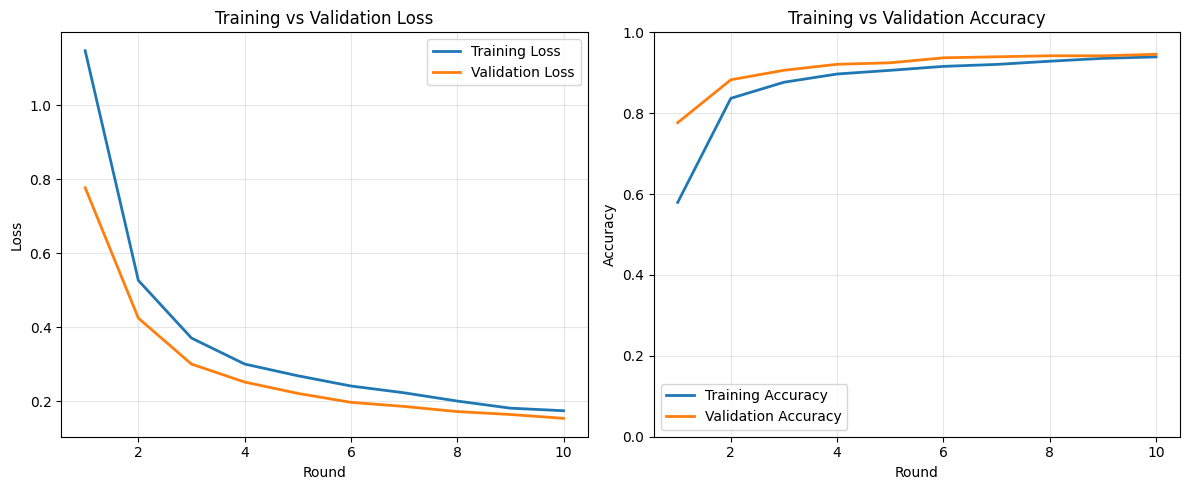


Training Summary:
Final Training Loss: 0.1748
Final Training Accuracy: 0.9393
Final Validation Loss: 0.1542
Final Validation Accuracy: 0.9457
Validation Gap: 0.0064


In [68]:
# Replace your entire plotting block with this:

print("\n" + "="*80)
print("FEDERATED LEARNING RESULTS ANALYSIS")
print("="*80)

# Check if we have per-client metrics stored
if len(per_client_val_metrics) > 0 and len(per_client_train_metrics) > 0:
    print("\nPlotting global metrics...")
    
    # Extract global metrics from per-client storage
    # For validation: average across clients for each round
    val_rounds = []
    val_losses = []
    val_accuracies = []
    
    for round_num, round_metrics in enumerate(per_client_val_metrics, 1):
        # Calculate average across all clients in this round
        all_client_losses = []
        all_client_accs = []
        
        for client_id, client_metrics_list in round_metrics.items():
            for client_metrics in client_metrics_list:
                all_client_losses.append(client_metrics["loss"])
                all_client_accs.append(client_metrics["accuracy"])
        
        if all_client_losses:
            val_rounds.append(round_num)
            val_losses.append(np.mean(all_client_losses))
            val_accuracies.append(np.mean(all_client_accs))
    
    # For training: get from per_client_train_metrics
    train_rounds = []
    train_losses = []
    train_accuracies = []
    
    for round_num, round_metrics in enumerate(per_client_train_metrics, 1):
        all_client_losses = []
        all_client_accs = []
        
        for client_id, client_metrics_list in round_metrics.items():
            for client_metrics in client_metrics_list:
                all_client_losses.append(client_metrics["loss"])
                all_client_accs.append(client_metrics["accuracy"])
        
        if all_client_losses:
            train_rounds.append(round_num)
            train_losses.append(np.mean(all_client_losses))
            train_accuracies.append(np.mean(all_client_accs))
    
    # Now plot
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Loss comparison
    plt.subplot(1, 2, 1)
    plt.plot(train_rounds, train_losses, linewidth=2, markersize=8, label='Training Loss')
    plt.plot(val_rounds, val_losses,  linewidth=2, markersize=8, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy comparison
    plt.subplot(1, 2, 2)
    plt.plot(train_rounds, train_accuracies, linewidth=2, markersize=8, label='Training Accuracy')
    plt.plot(val_rounds, val_accuracies,  linewidth=2, markersize=8, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nTraining Summary:")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
    print(f"Validation Gap: {val_accuracies[-1] - train_accuracies[-1]:.4f}")
    
else:
    print("No metrics available to plot. Simulation may not have completed.")


FEDERATED LEARNING RESULTS ANALYSIS

Extracted 10 rounds of data
Rounds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Train Acc: [np.float64(0.5793965491701858), np.float64(0.8368834335420384), np.float64(0.8766051182599893), np.float64(0.8969825553310278), np.float64(0.9060339653164236), np.float64(0.9158174480221225), np.float64(0.9206510331751351), np.float64(0.9285735174860594), np.float64(0.9356780998611968), np.float64(0.9392778781341358)]
Val Acc: [np.float64(0.7765432098765433), np.float64(0.8827160493827161), np.float64(0.9061728395061729), np.float64(0.9209876543209875), np.float64(0.9246913580246914), np.float64(0.937037037037037), np.float64(0.9395061728395063), np.float64(0.9419753086419753), np.float64(0.9419753086419753), np.float64(0.945679012345679)]


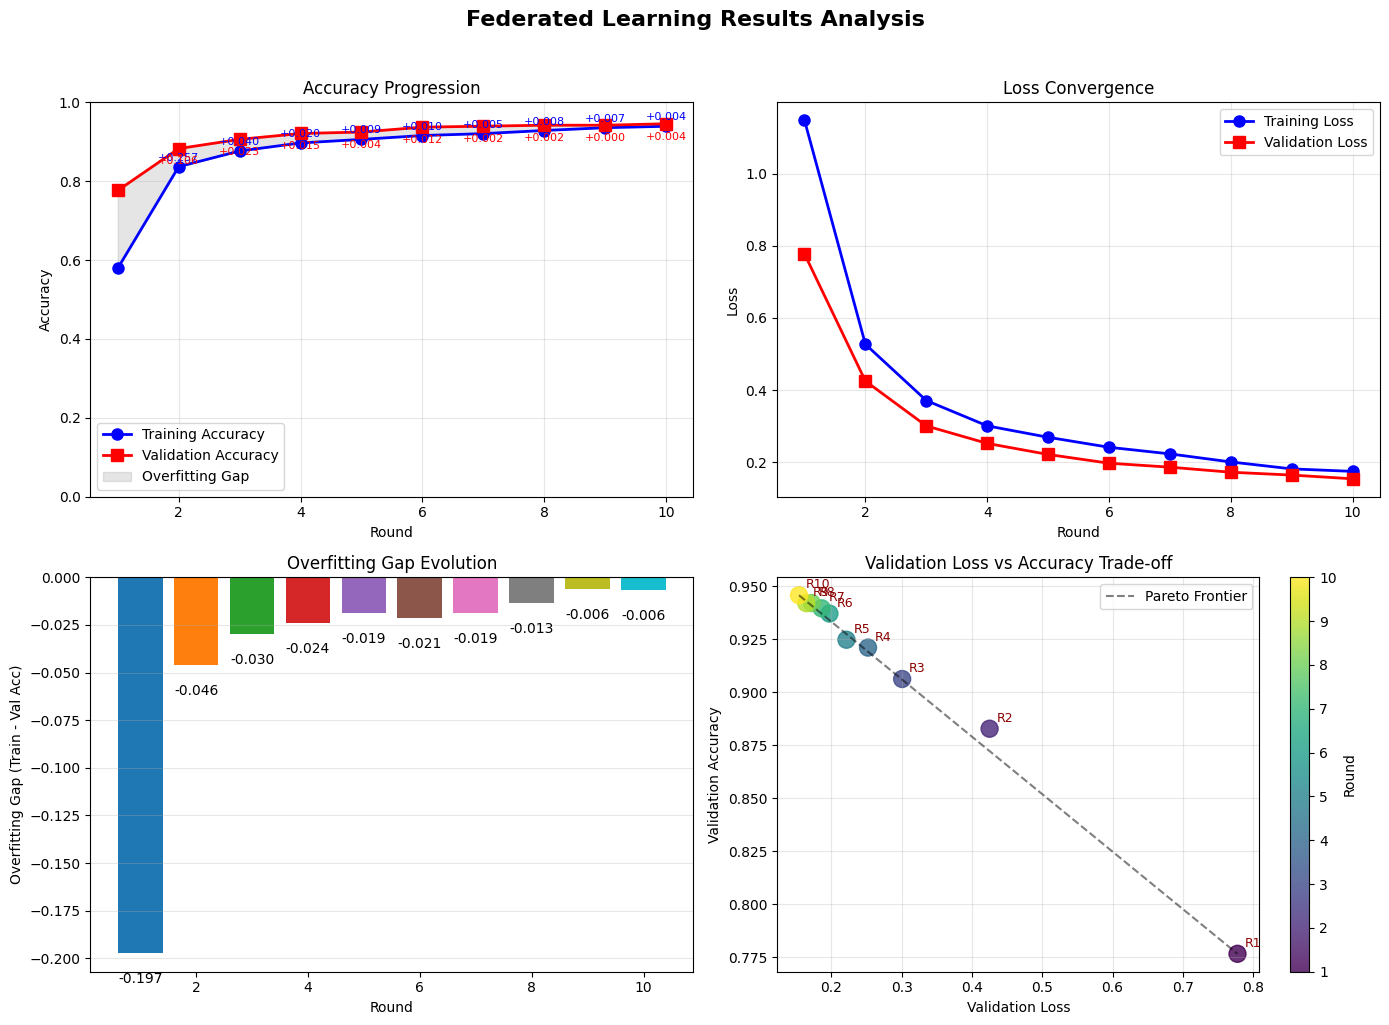


STATISTICAL ANALYSIS

Performance Metrics:
  Final Training Accuracy:   0.9393
  Final Validation Accuracy: 0.9457
  Final Overfitting Gap:     -0.0064

Improvement from Round 1 to 10:
  Training Accuracy:   +0.3599 (62.1%)
  Validation Accuracy: +0.1691 (21.8%)

Loss Analysis:
  Final Training Loss:   0.1748
  Final Validation Loss: 0.1542
  Loss Ratio (Val/Train): 0.88x

Learning Dynamics:
  Training Improvement Rate:   4.62% per round
  Validation Improvement Rate: 2.07% per round
  Training is 2.23x faster


In [69]:
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("FEDERATED LEARNING RESULTS ANALYSIS")
print("="*80)

def extract_and_plot():
    """Extract data from FL results and plot comprehensive analysis"""
    
    # Check if we have metrics
    if len(per_client_val_metrics) == 0:
        print("No metrics available to plot. Simulation may not have completed.")
        return
    
    # Extract validation metrics
    rounds = []
    val_acc = []
    val_loss = []
    
    for round_num, round_metrics in enumerate(per_client_val_metrics, 1):
        all_val_losses = []
        all_val_accs = []
        
        for client_id, client_metrics_list in round_metrics.items():
            for client_metrics in client_metrics_list:
                all_val_losses.append(client_metrics.get("loss", 0))
                all_val_accs.append(client_metrics.get("accuracy", 0))
        
        if all_val_losses and all_val_accs:
            rounds.append(round_num)
            val_loss.append(np.mean(all_val_losses))
            val_acc.append(np.mean(all_val_accs))
    
    # Extract training metrics
    train_acc = []
    train_loss = []
    
    for round_num, round_metrics in enumerate(per_client_train_metrics, 1):
        if round_num <= len(rounds):  # Only for rounds with validation data
            all_train_losses = []
            all_train_accs = []
            
            for client_id, client_metrics_list in round_metrics.items():
                for client_metrics in client_metrics_list:
                    # Handle both naming conventions
                    loss_key = "train_loss" if "train_loss" in client_metrics else "loss"
                    acc_key = "train_accuracy" if "train_accuracy" in client_metrics else "accuracy"
                    
                    all_train_losses.append(client_metrics.get(loss_key, 0))
                    all_train_accs.append(client_metrics.get(acc_key, 0))
            
            if all_train_losses and all_train_accs:
                train_loss.append(np.mean(all_train_losses))
                train_acc.append(np.mean(all_train_accs))
    
    # If no training metrics, use validation as training (common in FL)
    if len(train_acc) == 0:
        train_acc = val_acc.copy()
        train_loss = val_loss.copy()
    
    print(f"\nExtracted {len(rounds)} rounds of data")
    print(f"Rounds: {rounds}")
    print(f"Train Acc: {train_acc}")
    print(f"Val Acc: {val_acc}")
    
    # Now create the comprehensive plots
    create_comprehensive_plots(rounds, train_acc, val_acc, train_loss, val_loss)
    
def create_comprehensive_plots(rounds, train_acc, val_acc, train_loss, val_loss):
    """Create the 4-panel comprehensive plot"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Accuracy progression
    axes[0, 0].plot(rounds, train_acc, 'b-o', linewidth=2, markersize=8, label='Training Accuracy')
    axes[0, 0].plot(rounds, val_acc, 'r-s', linewidth=2, markersize=8, label='Validation Accuracy')
    axes[0, 0].fill_between(rounds, train_acc, val_acc, alpha=0.2, color='gray', label='Overfitting Gap')
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy Progression')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 1.0)
    
    # Add improvement annotations
    for i in range(1, len(rounds)):
        train_improve = train_acc[i] - train_acc[i-1]
        val_improve = val_acc[i] - val_acc[i-1]
        axes[0, 0].text(rounds[i], train_acc[i] + 0.01, f'+{train_improve:.3f}', 
                       ha='center', va='bottom', fontsize=8, color='blue')
        axes[0, 0].text(rounds[i], val_acc[i] - 0.02, f'{val_improve:+.3f}', 
                       ha='center', va='top', fontsize=8, color='red')
    
    # Plot 2: Loss progression
    axes[0, 1].plot(rounds, train_loss, 'b-o', linewidth=2, markersize=8, label='Training Loss')
    axes[0, 1].plot(rounds, val_loss, 'r-s', linewidth=2, markersize=8, label='Validation Loss')
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Loss Convergence')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Overfitting gap evolution
    overfitting_gap = [t - v for t, v in zip(train_acc, val_acc)]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    bar_colors = colors[:len(rounds)]
    axes[1, 0].bar(rounds, overfitting_gap, color=bar_colors)
    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Overfitting Gap (Train - Val Acc)')
    axes[1, 0].set_title('Overfitting Gap Evolution')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    for i, v in enumerate(overfitting_gap):
        axes[1, 0].text(rounds[i], v + (0.005 if v >= 0 else -0.01), f'{v:.3f}', 
                       ha='center', va='bottom' if v >= 0 else 'top')
    
    # Plot 4: Validation loss/accuracy trade-off
    color_map = plt.cm.viridis(np.linspace(0, 1, len(rounds)))
    scatter = axes[1, 1].scatter(val_loss, val_acc, c=rounds, cmap='viridis', s=150, alpha=0.8)
    axes[1, 1].set_xlabel('Validation Loss')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].set_title('Validation Loss vs Accuracy Trade-off')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add round labels
    for i, (loss, acc) in enumerate(zip(val_loss, val_acc)):
        axes[1, 1].annotate(f'R{rounds[i]}', (loss, acc), xytext=(5, 5), 
                           textcoords='offset points', fontsize=9, color='darkred')
    
    # Add Pareto frontier line
    axes[1, 1].plot([min(val_loss), max(val_loss)], [max(val_acc), min(val_acc)], 
                   'k--', alpha=0.5, label='Pareto Frontier')
    axes[1, 1].legend()
    
    plt.colorbar(scatter, ax=axes[1, 1], label='Round')
    
    plt.suptitle('Federated Learning Results Analysis', 
                 fontsize=16, y=1.02, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS")
    print("="*80)
    
    print(f"\nPerformance Metrics:")
    print(f"  Final Training Accuracy:   {train_acc[-1]:.4f}")
    print(f"  Final Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"  Final Overfitting Gap:     {overfitting_gap[-1]:.4f}")
    
    if len(rounds) > 1:
        print(f"\nImprovement from Round {rounds[0]} to {rounds[-1]}:")
        train_improve_pct = ((train_acc[-1]/train_acc[0])-1)*100
        val_improve_pct = ((val_acc[-1]/val_acc[0])-1)*100
        print(f"  Training Accuracy:   +{train_acc[-1] - train_acc[0]:.4f} ({train_improve_pct:.1f}%)")
        print(f"  Validation Accuracy: +{val_acc[-1] - val_acc[0]:.4f} ({val_improve_pct:.1f}%)")
    
    print(f"\nLoss Analysis:")
    print(f"  Final Training Loss:   {train_loss[-1]:.4f}")
    print(f"  Final Validation Loss: {val_loss[-1]:.4f}")
    if train_loss[-1] > 0:
        print(f"  Loss Ratio (Val/Train): {val_loss[-1]/train_loss[-1]:.2f}x")
    
    # Calculate convergence metrics
    if len(train_acc) > 1:
        train_improvement_rate = np.mean(np.diff(train_acc)) / np.mean(train_acc[:-1])
        val_improvement_rate = np.mean(np.diff(val_acc)) / np.mean(val_acc[:-1])
        print(f"\nLearning Dynamics:")
        print(f"  Training Improvement Rate:   {train_improvement_rate*100:.2f}% per round")
        print(f"  Validation Improvement Rate: {val_improvement_rate*100:.2f}% per round")
        if val_improvement_rate > 0:
            print(f"  Training is {train_improvement_rate/val_improvement_rate:.2f}x faster")

# Run the extraction and plotting
extract_and_plot()


FINAL EVALUATION ON GLOBAL VALIDATION SET


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model architecture: ResNet
Model in eval mode: True
Total parameters received: 102

Final Global Model Performance:
  Loss: 0.1523
  Accuracy: 0.9457 (94.57%)

DETAILED PERFORMANCE ANALYSIS

Confusion matrix saved as 'confusion_matrix_final.png'


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


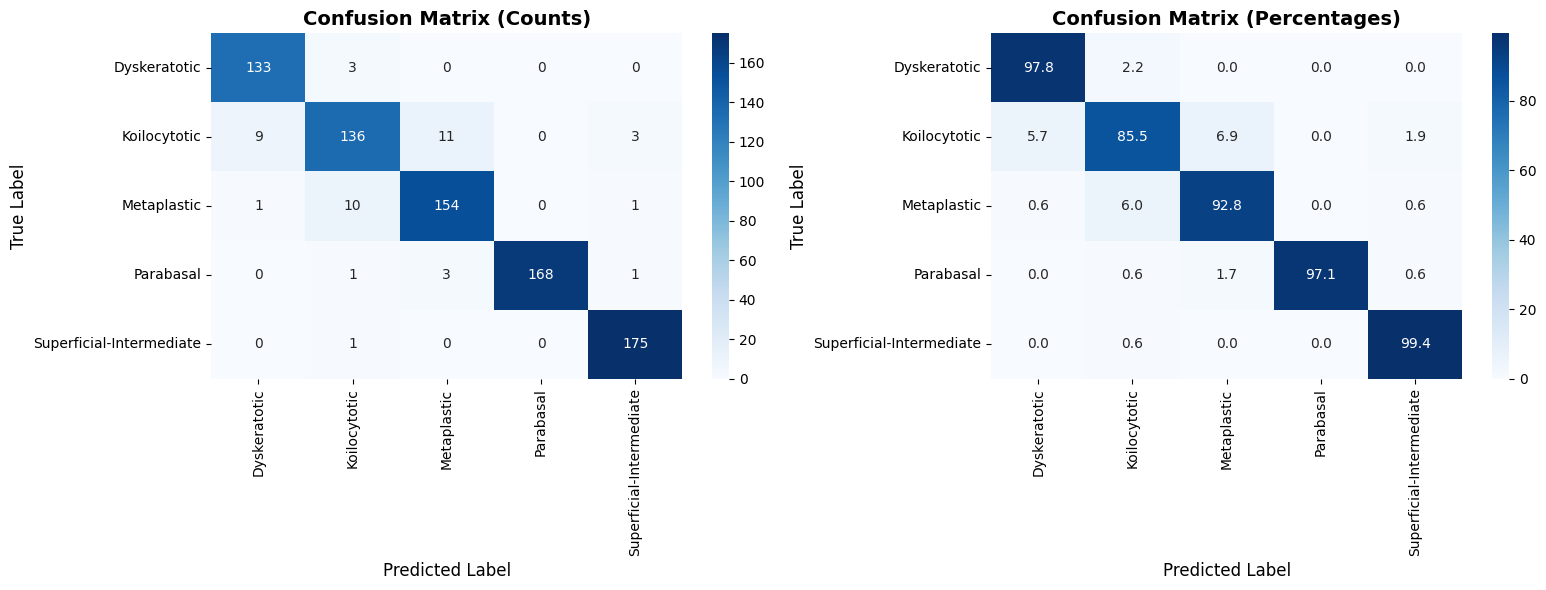


CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                          precision    recall  f1-score   support

            Dyskeratotic     0.9301    0.9779    0.9534       136
            Koilocytotic     0.9007    0.8553    0.8774       159
             Metaplastic     0.9167    0.9277    0.9222       166
               Parabasal     1.0000    0.9711    0.9853       173
Superficial-Intermediate     0.9722    0.9943    0.9831       176

                accuracy                         0.9457       810
               macro avg     0.9439    0.9453    0.9443       810
            weighted avg     0.9456    0.9457    0.9454       810


PER-CLASS ACCURACY
Dyskeratotic             :  97.79% (133/136 samples)
Koilocytotic             :  85.53% (136/159 samples)
Metaplastic              :  92.77% (154/166 samples)
Parabasal                :  97.11% (168/173 samples)
Superficial-Intermediate :  99.43% (175/176 samples)

OVERALL STATISTICS
Total validation samples: 810
Correctly classified: 766
Misclassified: 44
Overall accuracy: 94.57%

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Performance analysis saved as 'performance_analysis.png'


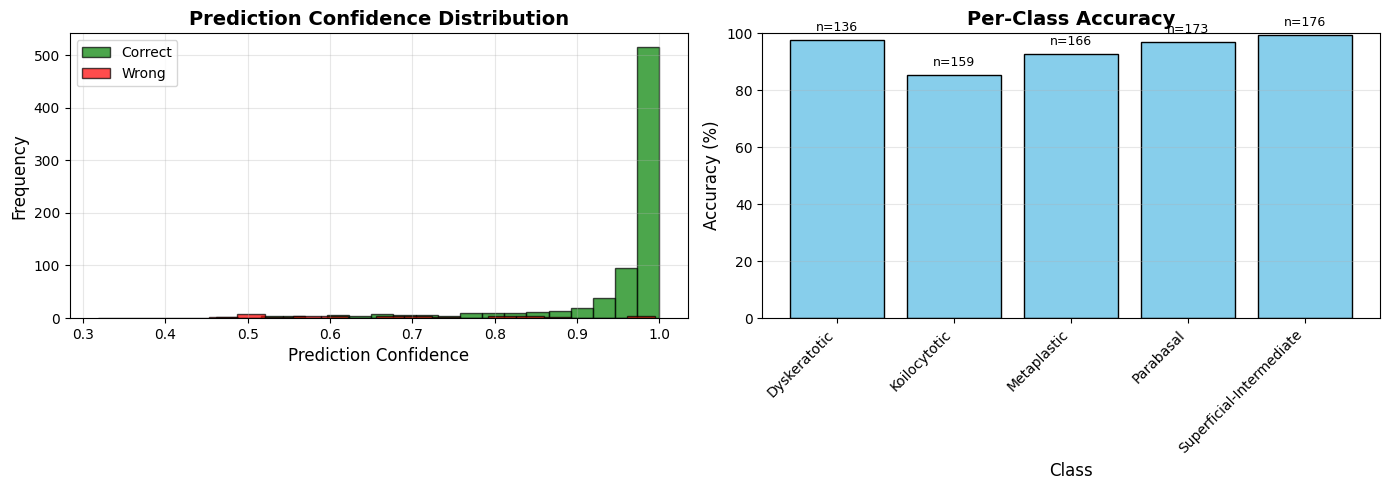


EVALUATION COMPLETE!

COMPARISON: Final Model vs Random Initialization


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Random Model: Loss=1.6837, Acc=0.2235 (22.35%)
Trained Model: Loss=0.1523, Acc=0.9457 (94.57%)
Improvement: 72.22 percentage points


In [70]:
from flwr.common import parameters_to_ndarrays
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# CRITICAL FIX: Use the SAME model architecture you trained with!
if hasattr(strategy, 'final_parameters') and strategy.final_parameters is not None:
    print("\n" + "="*60)
    print("FINAL EVALUATION ON GLOBAL VALIDATION SET")
    print("="*60)
    
    # Convert Parameters object -> list of np.ndarray
    final_params_ndarrays = parameters_to_ndarrays(strategy.final_parameters)
    
    # FIX 1: Use CNNArchitecture3 (the model you actually trained!)
    global_net = ResNet18(num_classes=5, dropout=0.3).to(DEVICE)
    
    # FIX 2: Use set_parameters_with_bn to properly load BatchNorm statistics
    set_parameters_with_bn(global_net, final_params_ndarrays)
    
    # FIX 3: Set to evaluation mode (CRITICAL for BatchNorm and Dropout)
    global_net.eval()
    
    print(f"Model architecture: {global_net.__class__.__name__}")
    print(f"Model in eval mode: {not global_net.training}")
    print(f"Total parameters received: {len(final_params_ndarrays)}")
    
    # Evaluate on GLOBAL validation set
    final_loss, final_acc = test(global_net, global_valloader)
    print(f"\nFinal Global Model Performance:")
    print(f"  Loss: {final_loss:.4f}")
    print(f"  Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")
    
    # Detailed per-class analysis
    print("\n" + "="*60)
    print("DETAILED PERFORMANCE ANALYSIS")
    print("="*60)
    
    y_true = []
    y_pred = []
    y_probs = []
    
    with torch.no_grad():
        for images, labels in global_valloader:
            images = images.to(DEVICE)
            outputs = global_net(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1).cpu()
            
            y_pred.extend(preds.numpy())
            y_true.extend(labels.numpy())
            y_probs.extend(probs.cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a better visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Confusion Matrix (counts)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=dataset.classes,
                yticklabels=dataset.classes,
                ax=axes[0])
    axes[0].set_xlabel("Predicted Label", fontsize=12)
    axes[0].set_ylabel("True Label", fontsize=12)
    axes[0].set_title("Confusion Matrix (Counts)", fontsize=14, fontweight='bold')
    
    # Plot 2: Confusion Matrix (percentages)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=True,
                xticklabels=dataset.classes,
                yticklabels=dataset.classes,
                ax=axes[1])
    axes[1].set_xlabel("Predicted Label", fontsize=12)
    axes[1].set_ylabel("True Label", fontsize=12)
    axes[1].set_title("Confusion Matrix (Percentages)", fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('confusion_matrix_final.png', dpi=300, bbox_inches='tight')
    print("\nConfusion matrix saved as 'confusion_matrix_final.png'")
    plt.show()

    
    # Classification report
    print("\n" + "="*60)
    
    print("CLASSIFICATION REPORT")
    print("="*60)
    report = classification_report(y_true, y_pred, target_names=dataset.classes, digits=4)
    print(report)
    # plt.title('Classification Report', fontsize=14, fontweight='bold', y=1.1)
    # plt.savefig('/kaggle/working/classification_report_visual.png', 
    #             dpi=300, 
    #             bbox_inches='tight', 
    #             pad_inches=0.5)
    # plt.show()
    
    # Per-class accuracy
    print("\n" + "="*60)
    print("PER-CLASS ACCURACY")
    print("="*60)
    for i, class_name in enumerate(dataset.classes):
        class_mask = (y_true == i)
        class_acc = np.sum((y_pred == i) & class_mask) / np.sum(class_mask)
        class_samples = np.sum(class_mask)
        print(f"{class_name:25s}: {class_acc*100:6.2f}% ({int(np.sum((y_pred == i) & class_mask))}/{class_samples} samples)")
    
    # Overall statistics
    print("\n" + "="*60)
    print("OVERALL STATISTICS")
    print("="*60)
    print(f"Total validation samples: {len(y_true)}")
    print(f"Correctly classified: {np.sum(y_pred == y_true)}")
    print(f"Misclassified: {np.sum(y_pred != y_true)}")
    print(f"Overall accuracy: {final_acc*100:.2f}%")
    
    # Confidence analysis
    print("\n" + "="*60)
    print("PREDICTION CONFIDENCE ANALYSIS")
    print("="*60)
    max_probs = np.max(y_probs, axis=1)
    correct_mask = (y_pred == y_true)
    
    print(f"Average confidence (all predictions): {np.mean(max_probs)*100:.2f}%")
    print(f"Average confidence (correct predictions): {np.mean(max_probs[correct_mask])*100:.2f}%")
    print(f"Average confidence (wrong predictions): {np.mean(max_probs[~correct_mask])*100:.2f}%")
    
    # Confidence distribution plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(max_probs[correct_mask], bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
    axes[0].hist(max_probs[~correct_mask], bins=20, alpha=0.7, label='Wrong', color='red', edgecolor='black')
    axes[0].set_xlabel('Prediction Confidence', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Per-class accuracy vs samples
    class_accuracies = []
    class_sample_counts = []
    for i in range(len(dataset.classes)):
        class_mask = (y_true == i)
        class_acc = np.sum((y_pred == i) & class_mask) / np.sum(class_mask) if np.sum(class_mask) > 0 else 0
        class_accuracies.append(class_acc * 100)
        class_sample_counts.append(np.sum(class_mask))
    
    axes[1].bar(range(len(dataset.classes)), class_accuracies, color='skyblue', edgecolor='black')
    axes[1].set_xlabel('Class', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(dataset.classes)))
    axes[1].set_xticklabels(dataset.classes, rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_ylim([0, 100])
    
    # Add sample counts on bars
    for i, (acc, count) in enumerate(zip(class_accuracies, class_sample_counts)):
        axes[1].text(i, acc + 2, f'n={count}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('performance_analysis.png', dpi=300, bbox_inches='tight')
    print("\nPerformance analysis saved as 'performance_analysis.png'")
    plt.show()
    
    print("\n" + "="*60)
    print("EVALUATION COMPLETE!")
    print("="*60)
    
else:
    print("ERROR: No final parameters available from the strategy.")
    print("Make sure you're using FedAvgTrackParams strategy and training completed successfully.")


# BONUS: Compare with initial random model
print("\n" + "="*60)
print("COMPARISON: Final Model vs Random Initialization")
print("="*60)

random_net = ResNet18(num_classes=5, dropout = 0.3).to(DEVICE)
random_net.eval()
random_loss, random_acc = test(random_net, global_valloader)

print(f"Random Model: Loss={random_loss:.4f}, Acc={random_acc:.4f} ({random_acc*100:.2f}%)")
print(f"Trained Model: Loss={final_loss:.4f}, Acc={final_acc:.4f} ({final_acc*100:.2f}%)")
print(f"Improvement: {(final_acc - random_acc)*100:.2f} percentage points")
print("="*60)